In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np
from tqdm import tqdm

In [2]:
import glob, re, pandas as pd, numpy as np
from tqdm import tqdm

# --------------------------------------------------
# 全局配置
# --------------------------------------------------
class Config:
    RESAMPLE         = '10min'       # 输出粒度
    FEATURES_COLS    = ['Voltage[V]', 'Current[A]', 'Temperature[°C]']
    START_TIME       = '2023-02-02'  # 每支 cell 的起始时间
    NAN_DROP_COLS    = FEATURES_COLS + ['SOH_ZHU']  # 这些列若仍 NaN 就整行丢弃

# --------------------------------------------------
# 工具函数
# --------------------------------------------------
def extract_cell_id(filepath):
    """df_01.parquet → '01'"""
    name = filepath.name if hasattr(filepath, 'name') else filepath
    m = re.search(r'df_(\d+)\.parquet', name)
    return m.group(1) if m else None

# --------------------------------------------------
# 核心处理
# --------------------------------------------------
def process_file(filepath,
                 resample_interval=Config.RESAMPLE,
                 start_time=Config.START_TIME):

    # 1) 读相关列
    df = pd.read_parquet(filepath)[
        ['Testtime[s]'] + Config.FEATURES_COLS + ['EFC', 'SOH_ZHU']
    ]

    # 2) 生成秒级 Datetime
    df['Datetime'] = pd.date_range(start=start_time, periods=len(df), freq='s')

    # 3) 10 min 重采样，针对不同列用不同聚合 👈
    agg_dict = {
        'Voltage[V]': 'mean',
        'Current[A]': 'mean',
        'Temperature[°C]': 'mean',
        'EFC': 'last',           # 累积量 → 取最后
        'SOH_ZHU': 'last',       # 慢变量 → 取最后
    }
    df = (df.set_index('Datetime')
            .resample(resample_interval)
            .agg(agg_dict)
            .reset_index())

    # 4) 仍含 NaN 的关键特征整行丢弃 👈
    df = df.dropna(subset=Config.NAN_DROP_COLS).reset_index(drop=True)

    # 5) 附加 cell_id
    df['cell_id'] = extract_cell_id(filepath)

    return df

# --------------------------------------------------
# 主流程
# --------------------------------------------------
parquet_files = glob.glob("Output/Calculated/df_*.parquet")
all_dfs = []

for file in tqdm(parquet_files, desc="Processing cells"):
    df_cell = process_file(file)
    all_dfs.append(df_cell)

df_resampled_all = pd.concat(all_dfs, ignore_index=True) if all_dfs else pd.DataFrame()

print('Resampled shape:', df_resampled_all.shape)
print(df_resampled_all.head())


Processing cells: 100%|██████████| 15/15 [01:07<00:00,  4.51s/it]

Resampled shape: (286702, 7)
             Datetime  Voltage[V]  Current[A]  Temperature[°C]        EFC  \
0 2023-02-05 14:50:00    2.553720    0.201622        27.812833  49.325391   
1 2023-02-05 15:00:00    3.280450    0.899268        26.599000  49.409492   
2 2023-02-05 15:10:00    3.328127    0.899238        26.590333  49.493590   
3 2023-02-05 15:20:00    3.365883    0.899302        26.604667  49.577695   
4 2023-02-05 15:30:00    3.378093    0.899277        26.739000  49.661797   

    SOH_ZHU cell_id  
0  0.999996      01  
1  0.999987      01  
2  0.999979      01  
3  0.999970      01  
4  0.999962      01  


In [11]:
# ------------------------------------------
# 1. 依赖
# ------------------------------------------
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import os

# ------------------------------------------
# 2. 数据与配置
# ------------------------------------------
df   = df_resampled_all
cols = ['Voltage[V]', 'Current[A]', 'Temperature[°C]',
    'EFC', 'SOH_ZHU']  

cell_ids = sorted(df['cell_id'].unique())    # 要绘制的电芯
save_dir = 'datas'                           # 保存目录
os.makedirs(save_dir, exist_ok=True)         # 若不存在就创建

# ------------------------------------------
# 3. 绘图并保存
# ------------------------------------------
for cid in cell_ids:
    sub = df[df['cell_id'] == cid]
    if sub.empty:
        continue

    fig, axes = plt.subplots(len(cols), 1,
                 figsize=(10, 2.0 * len(cols)),
                 sharex=True,
                 tight_layout=True)

    for ax, col in zip(axes, cols):
        ax.plot(sub['Datetime'], sub[col])
        ax.set_ylabel(col, fontsize=9)
        ax.grid(True, alpha=0.3)

        axes[0].set_title(f'Cell {cid} — full history', fontsize=12)
        axes[-1].set_xlabel('Datetime')

        # ---- 保存到文件 ----
        fname = os.path.join(save_dir, f'cell_{cid}.png')
        fig.savefig(fname, dpi=150)      # dpi 可按需调整
        plt.close(fig)                   # 关闭图像，节省内存

        print(f'Saved {fname}')


Saved datas\cell_01.png
Saved datas\cell_01.png
Saved datas\cell_01.png
Saved datas\cell_01.png
Saved datas\cell_01.png
Saved datas\cell_03.png
Saved datas\cell_03.png
Saved datas\cell_03.png
Saved datas\cell_03.png
Saved datas\cell_03.png
Saved datas\cell_05.png
Saved datas\cell_05.png
Saved datas\cell_05.png
Saved datas\cell_05.png
Saved datas\cell_05.png
Saved datas\cell_07.png
Saved datas\cell_07.png
Saved datas\cell_07.png
Saved datas\cell_07.png
Saved datas\cell_07.png
Saved datas\cell_09.png
Saved datas\cell_09.png
Saved datas\cell_09.png
Saved datas\cell_09.png
Saved datas\cell_09.png
Saved datas\cell_11.png
Saved datas\cell_11.png
Saved datas\cell_11.png
Saved datas\cell_11.png
Saved datas\cell_11.png
Saved datas\cell_13.png
Saved datas\cell_13.png
Saved datas\cell_13.png
Saved datas\cell_13.png
Saved datas\cell_13.png
Saved datas\cell_15.png
Saved datas\cell_15.png
Saved datas\cell_15.png
Saved datas\cell_15.png
Saved datas\cell_15.png
Saved datas\cell_17.png
Saved datas\cell

## Exploratory Data Analysis

In [4]:
# 查看行列维度
print("Rows,Cols:", df_resampled_all.shape)

# 列类型 & 非空计数
print(df_resampled_all.info())

# 缺失值汇总
print(df_resampled_all.isna().sum())

# 数值型特征简要统计
display(df_resampled_all[['Voltage[V]', 'Current[A]', 'Temperature[°C]', 'EFC', 'SOH_ZHU']].describe().T)


Rows,Cols: (286702, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286702 entries, 0 to 286701
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Datetime         286702 non-null  datetime64[ns]
 1   Voltage[V]       286702 non-null  float64       
 2   Current[A]       286702 non-null  float64       
 3   Temperature[°C]  286702 non-null  float64       
 4   EFC              286702 non-null  float64       
 5   SOH_ZHU          286702 non-null  float64       
 6   cell_id          286702 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 15.3+ MB
None
Datetime           0
Voltage[V]         0
Current[A]         0
Temperature[°C]    0
EFC                0
SOH_ZHU            0
cell_id            0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
Voltage[V],286702.0,3.312464,0.147608,1.999000,3.232805,3.344777,3.414066,3.650606
Current[A],286702.0,-0.000339,1.379665,-5.421800,-0.879400,0.179945,0.900243,1.866352
Temperature[°C],286702.0,28.331755,1.870537,24.707833,27.019333,27.745000,29.010667,39.184333
EFC,286702.0,1280.034374,788.023701,48.806085,635.717297,1182.748462,1851.140862,3065.203233
SOH_ZHU,286702.0,0.913639,0.077919,0.604311,0.890260,0.938938,0.964714,0.999998


| 特征                   | count    | mean        | std        | min       | 25%        | 50%         | 75%         | max         |
| -------------------- | -------- | ----------- | ---------- | --------- | ---------- | ----------- | ----------- | ----------- |
| **Voltage\[V]**      | 286702.0 | 3.312464    | 0.147608   | 1.999000  | 3.232805   | 3.344777    | 3.414066    | 3.650606    |
| **Current\[A]**      | 286702.0 | -0.000339   | 1.379665   | -5.421800 | -0.879400  | 0.179945    | 0.900243    | 1.866352    |
| **Temperature\[°C]** | 286702.0 | 28.331755   | 1.870537   | 24.707833 | 27.019333  | 27.745000   | 29.010667   | 39.184333   |
| **EFC**              | 286702.0 | 1280.034374 | 788.023701 | 48.806085 | 635.717297 | 1182.748462 | 1851.140862 | 3065.203233 |
| **SOH\_ZHU**         | 286702.0 | 0.913639    | 0.077919   | 0.604311  | 0.890260   | 0.938938    | 0.964714    | 0.999990    |

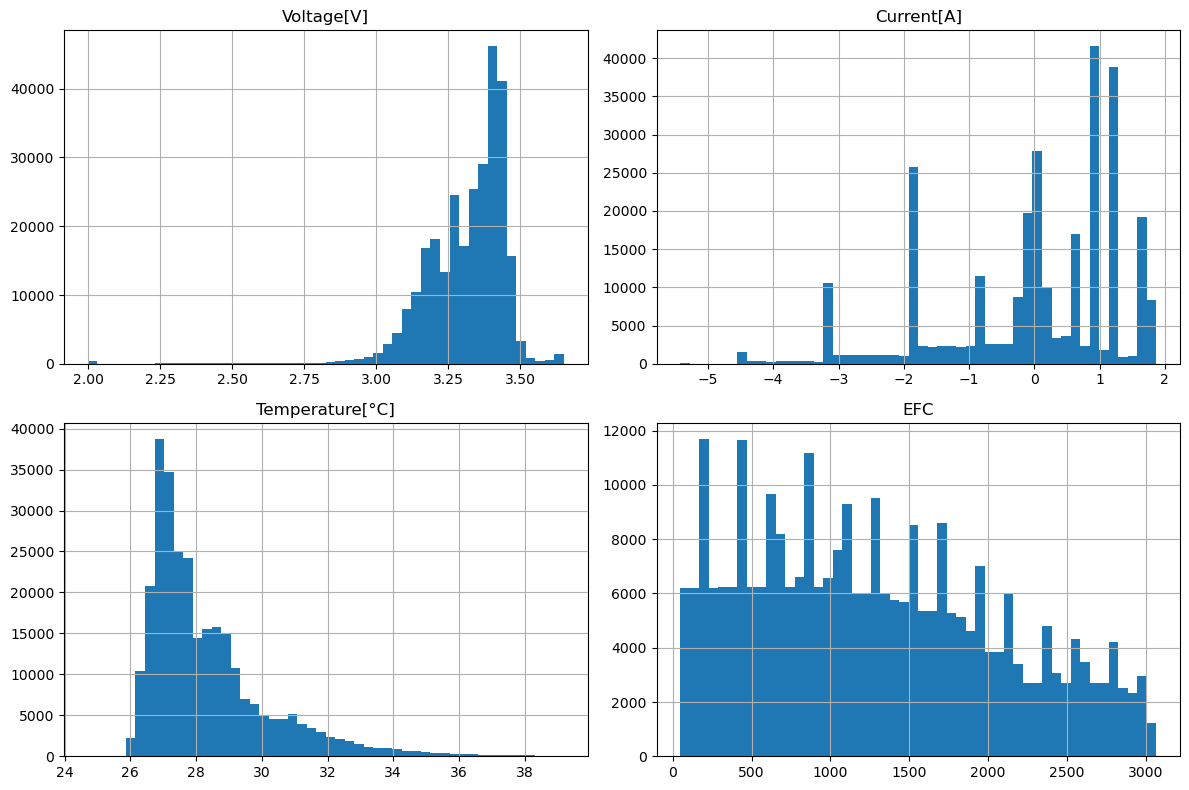

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, col in zip(axes.flatten(), ['Voltage[V]', 'Current[A]', 'Temperature[°C]', 'EFC']):
    df_resampled_all[col].hist(bins=50, ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()


- RobustScaler 利用中位数和 IQR（25%–75%）做缩放，不把极端电压/电流脉冲拖进均值、方差计算里，保留主要动态。

- StandardScaler 对近似正态的温度而言，会让数据服从标准正态，梯度更稳定。

- MinMaxScaler 把 EFC 这个单调递增量纲映射到（0，1），方便 LSTM 在多特征拼接时保持老化阶段的线性顺序。

|          特征          |                     分布 & 离群点                     |   推荐 Scaler  |                                       说明                                      |
| :------------------: | :----------------------------------------------: | :----------: | :---------------------------------------------------------------------------: |
|    **Voltage\[V]**   | 大多数集中在 \[3.2, 3.5] V 范围，少量低至 \~2 V 或高于 3.6 V 的离群 | RobustScaler | 用中位数和 IQR 缩放，能抑制那部分偶发的超低/超高尖峰。如果已清理掉 <2.3 V 的异常，也可改用 MinMaxScaler 映射到 \[0,1]。 |
|    **Current\[A]**   |           多个离散档位（-2、-1、0.9、1.8…），尾部有极值           | RobustScaler |                     离群值（短时强充/放电脉冲）很多，用 IQR 方法更鲁棒，不会把主干压扁。                     |
| **Temperature\[°C]** |           近似正态分布，中心在 28 °C 左右，但有若干高温尖点           | RobustScaler |           利用中位数和 IQR 对温度做缩放，能保持 27–29 °C 区间的微小波动，同时抑制 33 °C 以上的少量尖峰。          |
|        **EFC**       |                单调累积，分布从几十到三千多，右尾较长               | MinMaxScaler |                      直接线性映射到 \[0,1]，让 LSTM 顺着老化进程学“递增”模式。                     |


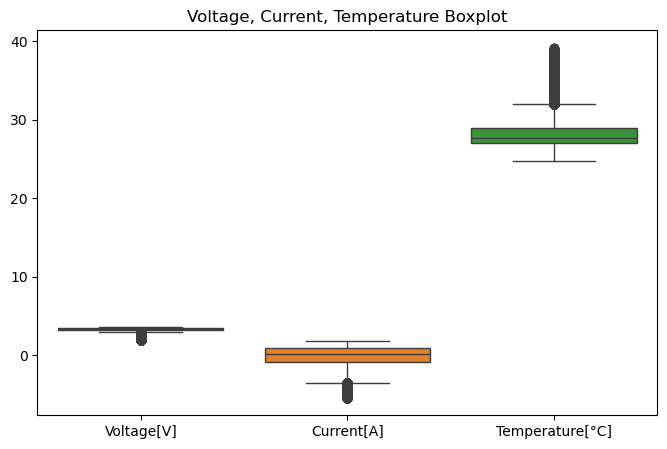

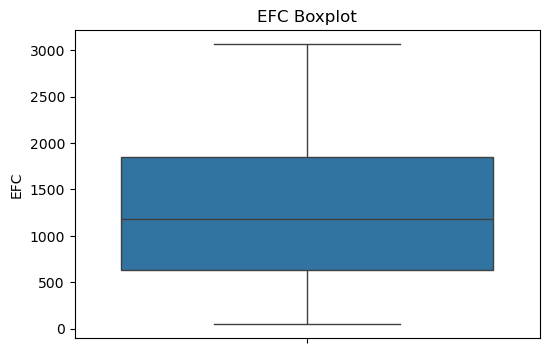

In [8]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_resampled_all[['Voltage[V]', 'Current[A]', 'Temperature[°C]']])
plt.title('Voltage, Current, Temperature Boxplot')
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(y=df_resampled_all['EFC'])
plt.title('EFC Boxplot')
plt.show()


## 平滑曲线方法

| 特性         | Savitzky–Golay 滤波                                       | EWMA（指数加权移动平均）                                             | 卡尔曼滤波（KF/EKF/UKF/AKF）                                                                                                         |
| ---------- | ------------------------------------------------------- | ---------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------- |
| **原理**     | 在每个长度为 $2m+1$ 的滑动窗口内，用最小二乘拟合 $k$ 次多项式，用多项式在中心点的拟合值替换原始点 | 对新观测按指数衰减权重与前次平滑值累加：<br>$s_t=\alpha x_t+(1-\alpha)s_{t-1}$ | 将 SOH 看作系统状态 $\mathbf x_t$，用线性/非线性状态空间模型：<br>$\mathbf x_t=F\mathbf x_{t-1}+w_t$，<br>$y_t=H\mathbf x_t+v_t$，<br>递推“预测→校正”得最优估计 |
| **实现方式**   | 非递归，每推一个新点都需拿出整个窗口重拟合                                   | 递归，仅一行更新公式，实时在线                                            | 递归，需要矩阵乘法、求逆（EKF 需雅可比，UKF 需 Sigma 点，AKF 还要在线估计噪声协方差）                                                                          |
| **延迟／滞后**  | 固定大约 $\tfrac{\text{window\_length}}{2}$ 个采样周期           | 平均滞后约 $\frac{1-\alpha}{\alpha}$ 个采样周期<br>（可调 α）            | 相位延迟最小（zero-phase 需双向滤波），卡尔曼增益自适应，滞后在最小均方误差意义下最优                                                                              |
| **拐点保留能力** | ★★★★  <br>多项式拟合可较好保留局部趋势与峰谷                             | ★★     <br>对突变会均匀平滑，拐点被抹平                                  | ★★–★★★<br>取决于模型中对突变的过程噪声假设，若 Q 较大可响应突变                                                                                        |
| **模型依赖**   | 无需任何先验模型                                                | 无需任何先验模型                                                   | 强依赖：需要精确定义过程/观测方程 & 器件噪声协方差 $Q,R$                                                                                             |
| **计算复杂度**  | O(window·poly\_order) per window                        | O(1) per 样本                                                | O(n²) per 样本（n=状态维度）；EKF/UKF/AKF 更高                                                                                           |
| **参数调优**   | 窗口长度 $2m+1$、多项式阶数 $k$                                   | 衰减因子 $\alpha$                                              | 过程噪声协方差 $Q$、观测噪声协方差 $R$、初始协方差 $P_0$                                                                                           |
| **鲁棒性**    | 对窗口外极端噪声敏感（需谨慎选窗口/阶数）                                   | 对任意噪声分布均可稳定衰减                                              | 对高斯噪声假设敏感，噪声/模型失配时易发散或过度平滑                                                                                                    |
| **在线／离线**  | 离线或批处理；不支持真正的流式实时更新                                     | 原生支持在线实时更新                                                 | 支持在线；但需部署完整滤波逻辑与模型方程                                                                                                          |
| **增量学习结合** | ❌ 难以在窗口外局部微调；每次需重拟合整个窗口                                 | ✅ 易于结合：可在每次更新后用平滑残差做在线小步长微调                                | ✅ 可在滤波过程中同时自适应更新 $Q,R$（AKF），并用滤波残差辅助微调                                                                                        |
| **典型应用场景** | 需要保留信号峰谷/拐点、对离线分析 & 后处理最优                               | 需要超轻量级在线平滑、可接受少量延迟、易调参                                     | 有准确物理或等效模型、需求最优贝叶斯估计、严格实时性 & 可解释性时                                                                                            |

